In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import json
import zipfile
import math

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
uploaded = files.upload()

Saving axis_40.zip to axis_40.zip


(100, 40, 40) (100, 4, 4) 140
[[ 0.48585603 -0.6807918  -0.54814798 -1.09629607]
 [-0.87403888 -0.3784349  -0.30470157 -0.60940319]
 [ 0.          0.62714374 -0.77890342 -1.55780697]
 [ 0.          0.          0.          1.        ]]


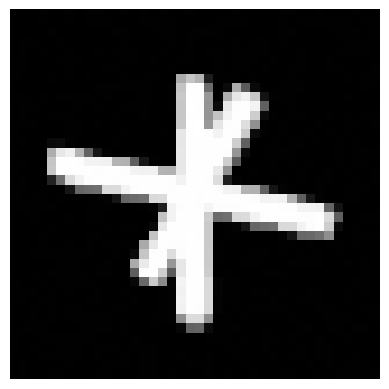

In [5]:
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')
with open('/content/dataset/transforms_train.json', 'r') as f:
    data = json.load(f)
with open('dataset/transforms_train.json', 'r') as f:
    data = json.load(f)
images = []
poses = []
for frame in data['frames']:
    img_path = f'dataset/' + frame['file_path'].replace('\\', '/')
    img = Image.open(img_path)
    img_array = np.array(img)
    images.append(img_array)
    poses.append(frame['transform_matrix'])

images = np.array(images) / 255
poses = np.array(poses)
focal = 140

H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[99], poses[99]
images = images[:99]
poses = poses[:99]

print(poses[5])
plt.imshow(images[22], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
#@title lego dataset (do not run)
# if not os.path.exists('tiny_nerf_data.npz'):
#     !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# data = np.load('tiny_nerf_data.npz')
# images = data['images']
# poses = data['poses']
# focal = data['focal']
# H, W = images.shape[1:3]
# print(images.shape, poses.shape, focal)

# testimg, testpose = images[101], poses[101]
# images = images[:100,...,:3]
# poses = poses[:100]

# print(type(poses[1]))
# plt.imshow(images[1])
# plt.show()

In [9]:
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.cast(tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d)), tf.float32)
    return tf.reshape(rays_o, (-1, 3)), tf.reshape(rays_d, (-1, 3))

In [10]:
def intersect_cube(rays_o, rays_d, cube_min, cube_max):
    t_min = (tf.cast(cube_min, tf.float32) - tf.cast(rays_o, tf.float32)) / tf.cast(rays_d, tf.float32)
    t_max = (tf.cast(cube_max, tf.float32) - tf.cast(rays_o, tf.float32)) / tf.cast(rays_d, tf.float32)

    t1 = tf.minimum(t_min, t_max)
    t2 = tf.maximum(t_min, t_max)

    t_near = tf.reduce_max(t1, axis=-1)
    t_far = tf.reduce_min(t2, axis=-1)
    valid = t_near < t_far

    t_near = tf.where(valid, t_near, tf.zeros_like(t_near))
    t_far = tf.where(valid, t_far, tf.zeros_like(t_far))

    camera_inside = tf.reduce_all((rays_o >= cube_min) & (rays_o <= cube_max), axis=-1)

    t1 = tf.where(camera_inside, tf.zeros_like(t_near), t_near)
    t2 = t_far

    return t1, t2

In [ ]:
#@title np implementation (do not run)
# def get_cosine_basis(field_min, field_max, max_freq):
#   functions = []
#   t = (field_max - field_min)/2
#   for i in range(max_freq):
#     for j in range(max_freq):
#       for k in range(max_freq):
#         @jax.jit
#         def func(x, y, z, i=i, j=j, k=k):  # Capture current values of i, j, k
#           return  jnp.cos(i * x * jnp.pi / t) * jnp.cos(j * y * jnp.pi / t) * jnp.cos(k * z * jnp.pi / t)
#         functions.append(func)
#   return functions


# # Apply each function to a new argument

# functions = get_cosine_basis(field_min, field_max, 2)
# new_argument = results = [f(0,0,0)[0] for f in functions]

# print(results)


[Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32)]


In [11]:
def get_cosine_basis(max_freq, period):
    numbers = tf.range(0, max_freq, dtype=tf.float32) * (2 * math.pi / period)
    numbers = tf.where(numbers == 0, tf.constant(10**-12, dtype=tf.float32), numbers)
    x, y, z = tf.meshgrid(numbers, numbers, numbers, indexing='ij')
    permutations = tf.reshape(tf.stack([x, y, z], axis=-1), (-1, 3))
    return permutations


In [ ]:
#@title np implementation (do not run)
# def get_cosine_basis(max_freq):
#     numbers = np.arange(1, max_freq+1)
#     x, y, z = np.meshgrid(numbers, numbers, numbers, indexing='ij')
#     permutations = np.stack([x, y, z], axis=-1).reshape(-1, 3)
#     return permutations

# cosine_basis = get_cosine_basis(max_freq)

In [12]:
def density(t, ray_o, ray_d, coefs, cosine_basis):
    para_eq = tf.reshape(ray_d * t + ray_o, (1, 3, -1))
    pq_basis = cosine_basis[:, :, tf.newaxis] * para_eq
    pq_cos = tf.reduce_prod(tf.cos(pq_basis), axis=1)
    return tf.linalg.matmul(coefs, pq_cos)

def density_integral(t0, t1, ray_o, ray_d, coefs, cosine_basis):
  q = cosine_basis[:, tf.newaxis, :]
  qo = q * ray_o[tf.newaxis, :, :]
  qd = q * ray_d[tf.newaxis, :, :]

  sin1_qo = qo[:,:,0] - qo[:,:,1] - qo[:,:,2]
  sin1_qd = qd[:,:,0] - qd[:,:,1] - qd[:,:,2]

  sin2_qo = qo[:,:,0] + qo[:,:,1] - qo[:,:,2]
  sin2_qd = qd[:,:,0] + qd[:,:,1] - qd[:,:,2]

  sin3_qo = qo[:,:,0] - qo[:,:,1] + qo[:,:,2]
  sin3_qd = qd[:,:,0] - qd[:,:,1] + qd[:,:,2]

  sin4_qo = qo[:,:,0] + qo[:,:,1] + qo[:,:,2]
  sin4_qd = qd[:,:,0] + qd[:,:,1] + qd[:,:,2]

  sin1_qd = tf.where(sin1_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin1_qd)
  sin2_qd = tf.where(sin2_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin2_qd)
  sin3_qd = tf.where(sin3_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin3_qd)
  sin4_qd = tf.where(sin4_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin4_qd)

  t0 =  tf.reshape(t0, [1, -1])
  t1 =  tf.reshape(t1, [1, -1])

  res_vec = 1/4 * (
        (tf.sin(sin1_qo + sin1_qd * t0) - tf.sin(sin1_qo + sin1_qd * t1)) / sin1_qd +
        (tf.sin(sin2_qo + sin2_qd * t0) - tf.sin(sin2_qo + sin2_qd * t1)) / sin2_qd +
        (tf.sin(sin3_qo + sin3_qd * t0) - tf.sin(sin3_qo + sin3_qd * t1)) / sin3_qd +
        (tf.sin(sin4_qo + sin4_qd * t0) - tf.sin(sin4_qo + sin4_qd * t1)) / sin4_qd
    )
  density = tf.clip_by_value(1 - tf.exp(tf.linalg.matmul(coefs, res_vec)), clip_value_min=0, clip_value_max=1)
  return density


def density_grad_sse(t0, t1, ray_o, ray_d, coefs, cosine_basis,ground_truth):
  q = cosine_basis[:, tf.newaxis, :]
  qo = q * ray_o[tf.newaxis, :, :]
  qd = q * ray_d[tf.newaxis, :, :]

  sin1_qo = qo[:,:,0] - qo[:,:,1] - qo[:,:,2]
  sin1_qd = qd[:,:,0] - qd[:,:,1] - qd[:,:,2]

  sin2_qo = qo[:,:,0] + qo[:,:,1] - qo[:,:,2]
  sin2_qd = qd[:,:,0] + qd[:,:,1] - qd[:,:,2]

  sin3_qo = qo[:,:,0] - qo[:,:,1] + qo[:,:,2]
  sin3_qd = qd[:,:,0] - qd[:,:,1] + qd[:,:,2]

  sin4_qo = qo[:,:,0] + qo[:,:,1] + qo[:,:,2]
  sin4_qd = qd[:,:,0] + qd[:,:,1] + qd[:,:,2]

  sin1_qd = tf.where(sin1_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin1_qd)
  sin2_qd = tf.where(sin2_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin2_qd)
  sin3_qd = tf.where(sin3_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin3_qd)
  sin4_qd = tf.where(sin4_qd == 0, tf.constant(10**-10, dtype=tf.float32), sin4_qd)

  t0 =  tf.reshape(t0, [1, -1])
  t1 =  tf.reshape(t1, [1, -1])

  res_vec = 1/4 * (
        (tf.sin(sin1_qo + sin1_qd * t0) - tf.sin(sin1_qo + sin1_qd * t1)) / sin1_qd +
        (tf.sin(sin2_qo + sin2_qd * t0) - tf.sin(sin2_qo + sin2_qd * t1)) / sin2_qd +
        (tf.sin(sin3_qo + sin3_qd * t0) - tf.sin(sin3_qo + sin3_qd * t1)) / sin3_qd +
        (tf.sin(sin4_qo + sin4_qd * t0) - tf.sin(sin4_qo + sin4_qd * t1)) / sin4_qd
    )
  density = tf.clip_by_value(1 - tf.exp(tf.linalg.matmul(coefs, res_vec)), clip_value_min=0, clip_value_max=1)
  mse = tf.reduce_sum((density - ground_truth)**2)/len(ground_truth)
  grad = tf.reduce_sum((density - ground_truth) * (density - 1) * res_vec, axis = 1)
  return grad, mse.numpy().item()

In [ ]:
#@title np implementation (do not run)
# def density(t, ray_o, ray_d, coefs, cosine_basis):
#   para_eq = (ray_d * t + ray_o).reshape(1,3,-1)
#   pq_basis = cosine_basis[:, :, np.newaxis] * para_eq
#   return coefs @ np.prod(np.cos(pq_basis),axis = 1)

# training

In [7]:
#@title load coefs from pc (check file name)
loaded_data = files.upload()
loaded_npz = np.load('coefs_save (13).npz')
coefs_save = loaded_npz['coefs_save']

Saving coefs_save (13).npz to coefs_save (13) (1).npz


In [ ]:
half_field = 0.25
field_min = np.array([-0.2, -0.2, -0.2])
field_max = np.array([0.2, 0.2, 0.2])
max_freq = 20
cosine_basis = get_cosine_basis(max_freq,half_field)
coefs = tf.zeros((1, max_freq**3), dtype=tf.float32)
# coefs = coefs_save
ground_truth = tf.convert_to_tensor(images.reshape(-1, H*W), dtype=tf.float32)[:20]

learning_rate = 0.01
epochs = 500

for e in range(epochs):
  grad = tf.zeros_like(coefs)
  mse = 0
  for i in range(len(ground_truth)):
    camera = poses[i]
    gt = ground_truth[i]
    rays_o, rays_d = get_rays(H, W, focal, camera)
    t0, t1 = intersect_cube(rays_o, rays_d, field_min, field_max)
    g, m = density_grad_sse(t0, t1, rays_o, rays_d, coefs, cosine_basis,gt)
    grad += g / (len(ground_truth))
    mse += m / (len(ground_truth))

  coefs -= learning_rate * grad
  print("epoch", e + 1, " -- mse:", mse)








epoch 1  -- mse: 0.08037359267473222
epoch 2  -- mse: 0.05125879012048244
epoch 3  -- mse: 0.04703952372074127
epoch 4  -- mse: 0.04408186431974173
epoch 5  -- mse: 0.04183610137552023
epoch 6  -- mse: 0.040065902285277843
epoch 7  -- mse: 0.038630881160497677
epoch 8  -- mse: 0.03743886426091195
epoch 9  -- mse: 0.03642689054831863
epoch 10  -- mse: 0.03555065616965294
epoch 11  -- mse: 0.03477873466908932
epoch 12  -- mse: 0.034088291507214305
epoch 13  -- mse: 0.03346327822655439
epoch 14  -- mse: 0.03289190931245685
epoch 15  -- mse: 0.03236516881734133
epoch 16  -- mse: 0.031876055896282195
epoch 17  -- mse: 0.03141903504729271
epoch 18  -- mse: 0.030989959556609395
epoch 19  -- mse: 0.030585298500955108
epoch 20  -- mse: 0.030202137026935815
epoch 21  -- mse: 0.029838038887828586
epoch 22  -- mse: 0.029491178784519432
epoch 23  -- mse: 0.029159913305193182
epoch 24  -- mse: 0.028842830751091238
epoch 25  -- mse: 0.02853873502463102
epoch 26  -- mse: 0.0282465965487063
epoch 27  -

In [ ]:
coefs_save = coefs

In [ ]:
#@title save coefs on pc
np.savez('coefs_save.npz', coefs_save=coefs_save)
files.download('coefs_save.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

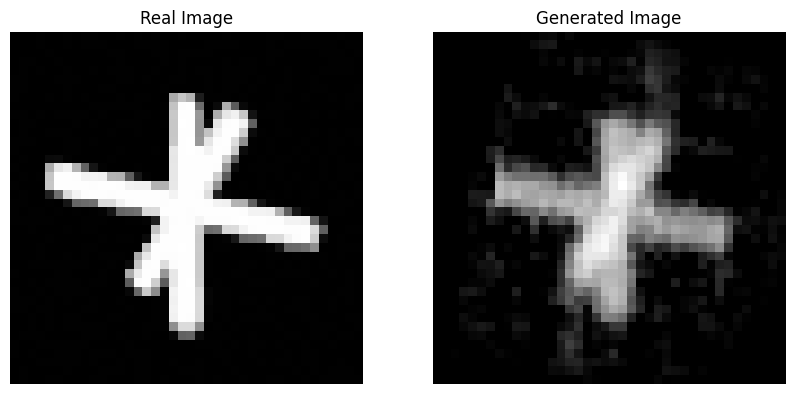

In [18]:
# testing

i = 22
camera = poses[i]
half_field = 0.25
field_min = np.array([-0.2, -0.2, -0.2])
field_max = np.array([0.2, 0.2, 0.2])
max_freq = 20
cosine_basis = get_cosine_basis(max_freq,half_field)
rays_o, rays_d = get_rays(H, W, focal, camera)
t0, t1 = intersect_cube(rays_o, rays_d, field_min, field_max)
tf_image = density_integral(t0, t1, rays_o, rays_d, coefs, cosine_basis)
np_image = tf_image.numpy().reshape(H, W)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[i], cmap='gray')
plt.axis('off')
plt.title('Real Image')

plt.subplot(1, 2, 2)
plt.imshow(np_image, cmap='gray')
plt.title('Generated Image')
plt.axis('off')
plt.show()


In [ ]:
positive_elements = coefs[coefs > 0]
mean_positive = np.mean(positive_elements)

# Calculate the mean of negative elements
negative_elements = coefs[coefs < 0]
mean_negative = np.mean(negative_elements)

# Count the number of elements close to 0 (within a small tolerance, e.g., 1e-5)
tolerance = 0.18
close_to_zero_count = np.sum(np.abs(coefs) < tolerance)

print("Mean of positive elements:", mean_positive)
print("Mean of negative elements:", mean_negative)
print("Number of elements close to 0:", close_to_zero_count)

coefs_zerod = coefs.numpy().copy()
coefs_zerod[np.abs(coefs_zerod) < tolerance] = 0

Mean of positive elements: 0.07343558
Mean of negative elements: -0.06003769
Number of elements close to 0: 7480
